<a href="https://colab.research.google.com/github/maxxies/stock_prediction_pricing/blob/main/Stock_pricing_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Project based libraries**

In [67]:
import quandl
import math
import pandas as pd
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import datetime
import matplotlib.pyplot as plt
import matplotlib

**Loading data**

In [68]:
df = quandl.get('WIKI/GOOGL', authtoken='f-h9Kzc9PzkmN1pHpihe')

**Feature engineering**

In [69]:
# Feature selection
df = df[['Adj. Close', 'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Volume',]]

# Feature extraction
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df['PCT_Change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

# New feature selection
df = df[['Adj. Close', 'HL_PCT', 'PCT_Change', 'Adj. Volume',]]
df.tail(30)


,Adj. Close,HL_PCT,PCT_Change,Adj. Volume
Date,,,,
2018-02-13,1054.14,0.671638,0.394286,1574121.0
2018-02-14,1072.70,0.258227,1.743304,2029979.0
2018-02-15,1091.36,0.251063,0.730075,1806206.0
2018-02-16,1095.50,1.169329,0.193894,1971928.0
2018-02-20,1103.59,1.150790,0.991068,1646405.0
2018-02-21,1113.75,2.015713,0.419259,2024534.0
2018-02-22,1109.90,1.401928,-0.828292,1386115.0
2018-02-23,1128.09,0.080667,0.842973,1234539.0
2018-02-26,1143.70,0.043718,1.046066,1489118.0


**Labels/Targets**

In [70]:
forecast_col = 'Adj. Close'
df.fillna(-9999, inplace=True)
forecast_out = int(math.ceil(0.009 * len(df))) 
df['label'] = df.loc[:,(forecast_col)].shift(-forecast_out) # Shifts future prices as labels for past dates
print(forecast_out) # Number of stocks to shift
df.tail(35)

31


,Adj. Close,HL_PCT,PCT_Change,Adj. Volume,label
Date,,,,,
2018-02-06,1084.43,0.272032,4.879205,3732527.0,1053.15
2018-02-07,1055.41,2.948617,-2.724499,2544683.0,1026.55
2018-02-08,1005.60,5.800517,-5.120439,3067173.0,1054.09
2018-02-09,1043.43,0.794495,1.710726,4436032.0,1006.94
2018-02-12,1054.56,1.044037,-0.199684,2796258.0,NaN
2018-02-13,1054.14,0.671638,0.394286,1574121.0,NaN
2018-02-14,1072.70,0.258227,1.743304,2029979.0,NaN
2018-02-15,1091.36,0.251063,0.730075,1806206.0,NaN
2018-02-16,1095.50,1.169329,0.193894,1971928.0,NaN


 **Splitting data**

In [71]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
df.dropna(inplace=True)
y = np.array(df.loc[:,('label')])
train_X, test_X, train_y, test_y = train_test_split(X, y , shuffle=True, test_size=0.2)


**Model Selection using an ensemble method**

In [72]:
lr_clf = LinearRegression()
dt_clf = DecisionTreeRegressor()
kn_clf = KNeighborsRegressor()
svm_clf = svm.SVR(kernel='poly')
voting_clf = voting_clf = VotingRegressor(estimators=[('lr', lr_clf), ('svm', svm_clf), ('dt', dt_clf), ('kn', kn_clf)])

for clf in (lr_clf, dt_clf, kn_clf, svm_clf, voting_clf):
    clf.fit(train_X, train_y)
    print(clf.__class__.__name__, clf.score(test_X,test_y))


LinearRegression 0.9799513362366943
DecisionTreeRegressor 0.9760084662584914
KNeighborsRegressor 0.9724620677327018
SVR 0.620382021902394
VotingRegressor 0.9579634627244236


**Forecasting predictions**

In [73]:

df['Forecast']= np.nan
forecast_set = lr_clf.predict(X_lately)
last_date = df.iloc[-1].name
print(last_date)
last_unix = last_date.timestamp()
one_day = 84600
next_unix = last_unix + one_day

for forecast in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] =[np.nan for _ in range(len(df.columns)-1)] + [forecast]
df.tail(32)

2018-02-09 00:00:00


,Adj. Close,HL_PCT,PCT_Change,Adj. Volume,label,Forecast
Date,,,,,,
2018-02-09 00:00:00,1043.43,0.794495,1.710726,4436032.0,1006.94,NaN
2018-02-09 23:30:00,NaN,NaN,NaN,NaN,NaN,1069.750555
2018-02-10 23:00:00,NaN,NaN,NaN,NaN,NaN,1069.988712
2018-02-11 22:30:00,NaN,NaN,NaN,NaN,NaN,1088.573986
2018-02-12 22:00:00,NaN,NaN,NaN,NaN,NaN,1107.765597
2018-02-13 21:30:00,NaN,NaN,NaN,NaN,NaN,1110.929734
2018-02-14 21:00:00,NaN,NaN,NaN,NaN,NaN,1118.935825
2018-02-15 20:30:00,NaN,NaN,NaN,NaN,NaN,1128.164378
2018-02-16 20:00:00,NaN,NaN,NaN,NaN,NaN,1125.663395


**Plotting predictions**

<IPython.core.display.Javascript object>

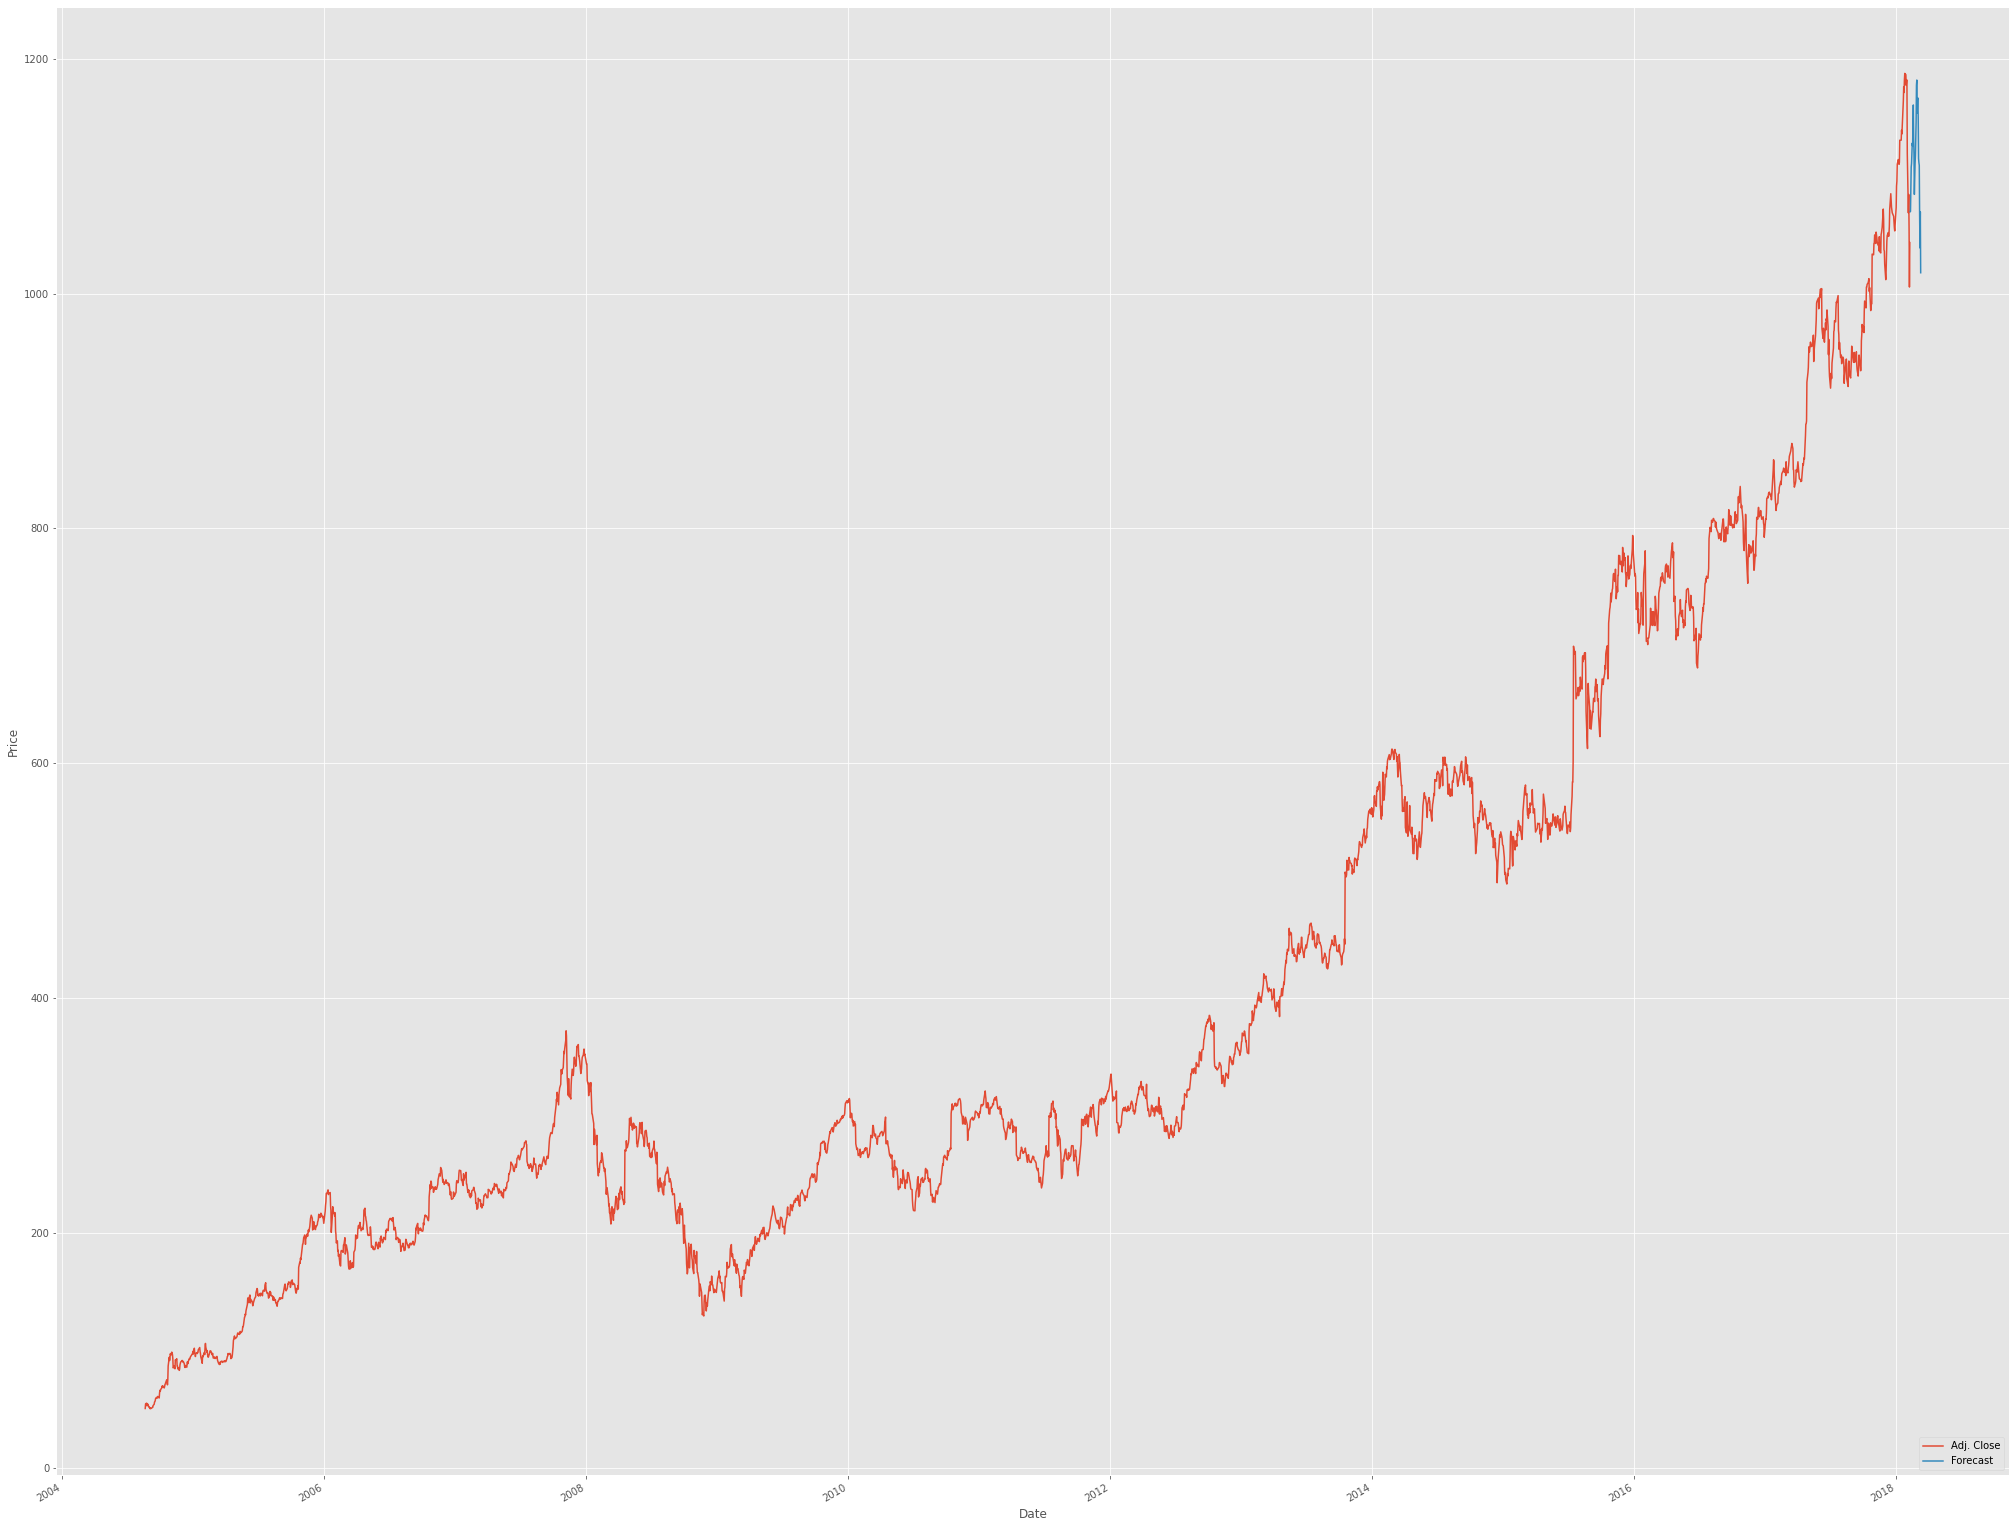

In [74]:
# %matplotlib inline
matplotlib.use('nbagg')
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.rcParams["figure.figsize"]=35,30
plt.show()